In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from librosa import lpc
from scipy.io import wavfile
import sounddevice as sd
from scipy.signal import freqz
import librosa
from IPython.display import Audio

#### 1

##### 1.1

In [328]:
# function to synthetis an autoregressive (AR) process of length N, defined by its AR coefficients and the innovation variance σ2 .
def AR(N, coefs, sigma2):
    Z = np.random.normal(0, np.sqrt(sigma2), N)
    X = np.zeros(N)
    for i in range(N):
        X[i] = Z[i]
        for j in range(len(coefs)):
            X[i] += coefs[j] * X[i-j-1]
    return X

##### 1.2 Non-parametric estimation : periodogram

Code a function that computes and displays the periodogram of a given input signal, allowing to
choose between the standard method and the Bartlett and Welsh methods.

In [4]:
def periodogram(X,Bartlett= False ,Welch = False, plot = True):
    N = len(X)
    if(Bartlett):
        # Bartlett method
        freq = np.fft.fftfreq(N)
        periodogram_values = []
        
        M = int(np.sqrt(N))
        L = int(N/M)
        
        for mu in range(N):
            periodogram_r = 0
            for l in range(L):
                periodogram_ = np.fft.fft(X[l*M : l*M + M], n = N)
                periodogram_r += np.abs(periodogram_[mu]) ** 2
            periodogram_values += [periodogram_r / (L*M)]
        
        # remove negative frequencies
        periodogram_values = np.array(periodogram_values)[freq >= 0]
        freq = np.array(freq)[freq >= 0]
    elif(Welch):
        # Welch method
        freq = np.fft.fftfreq(N)
        periodogram_values = []

        # Parameters
        M = int(np.sqrt(N))
        K = int(M /2)
        S = int( 2 * N / M)

        # Window
        window = np.bartlett(M)
        P = np.sum(window**2) / M   #Power of the window
        for mu in range(N):
            periodogram_r = 0
            for i in range(S):
                if(len(X[i*K : i*K + M]) != M):
                    break
                periodogram_ = np.fft.fft(X[i*K : i*K + M]*window, n = N)
                periodogram_r += np.abs(periodogram_[mu]) ** 2
            periodogram_values += [periodogram_r]
            
        periodogram_values = periodogram_values / (S*M*P)

        # remove negative frequencies
        periodogram_values = periodogram_values[freq >= 0]
        freq = freq[freq >= 0]

    else:
        # periodogram 
        periodogram_values = np.abs(np.fft.fft(X))**2 / N
        freq = np.fft.fftfreq(N)
        # remove negative frequencies
        periodogram_values = periodogram_values[freq >= 0]
        freq = freq[freq >= 0]
    

    if(plot):
        plt.plot(freq, 10*np.log10(periodogram_values))
        plt.xlabel('Frequency')
        plt.ylabel('Periodogram')
        if (Bartlett):
            plt.title('Periodogram with Bartlett method')
        else:
            plt.title('Periodogram')
        plt.show()

    
    return freq, periodogram_values

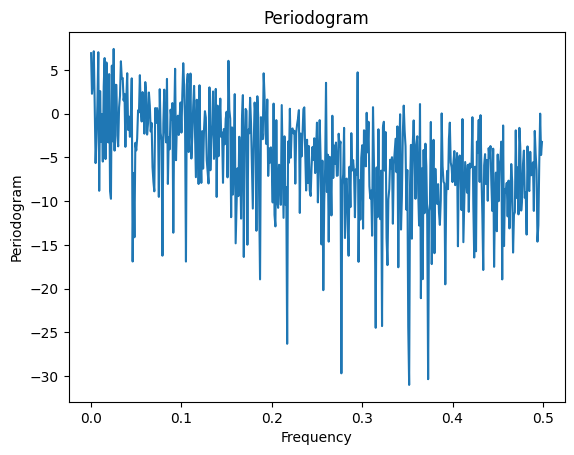

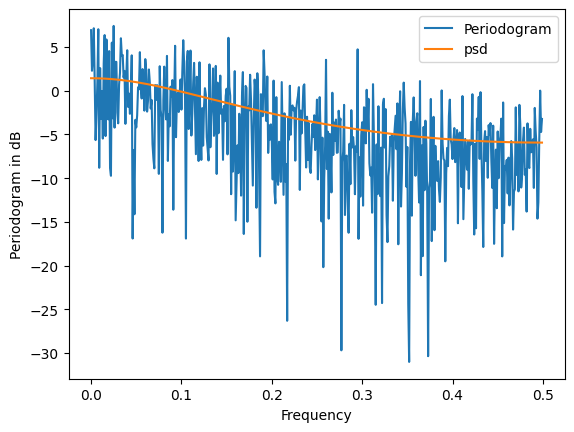

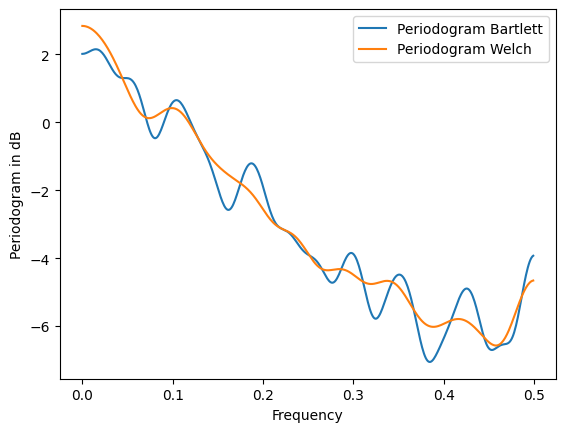

In [330]:
## AR process of order 1, length 100, with coefficients -0.2, and innovation variance 0.5
N = 1000
coefs = [0.4]
sigma2 = 0.5
X = AR(N, coefs, sigma2)

# periodogram of the AR process
freq1, per1 = periodogram(X)

# using Bartlett method
freq2, per2 = periodogram(X, Bartlett = True, plot = False)

# turn in to dB
per1 = 10 * np.log10(per1)
per2 = 10 * np.log10(per2)

# using Welch method
freq3, per3 = periodogram(X, Welch = True, plot = False)
per3 = 10 * np.log10(per3)

# theorical PSD 
theoritical_psd = sigma2 / ( np.abs(1 - coefs[0] * np.exp(-2j*np.pi* freq1))**2)
theoritical_psd = 10 * np.log10(theoritical_psd)

plt.plot(freq2, per1, label = 'Periodogram')
plt.plot(freq1, theoritical_psd, label = 'psd')
plt.xlabel('Frequency')
plt.ylabel('Periodogram in dB')
plt.legend()
plt.show()


plt.plot(freq2, per2, label = 'Periodogram Bartlett')
plt.plot(freq3, per3, label = 'Periodogram Welch')
plt.xlabel('Frequency')
plt.ylabel('Periodogram in dB')
plt.legend()
plt.show()

1.2.4 Experimentaly compare these different estimators in terms of bias and variance.

In [331]:
bias1 = np.mean(theoritical_psd - per1)
bias2 = np.mean(theoritical_psd - per2)
bias3 = np.mean(theoritical_psd - per3)

var1 = np.var(theoritical_psd - per1)
var2 = np.var(theoritical_psd - per2)
var3 = np.var(theoritical_psd - per3)

print('Bias and variance of the estimates')
print('---------------------------------------------')
print('Periodogram :')
print('Bias : ', bias1)
print('Variance : ', var1)
print('---------------------------------------------')
print('Periodogram Bartlett :')
print('Bias : ', bias2)
print('Variance : ', var2)
print('---------------------------------------------')
print('Periodogram Welch :')
print('Bias : ', bias3)
print('Variance : ', var3)
print('---------------------------------------------')

Bias and variance of the estimates
---------------------------------------------
Periodogram :
Bias :  2.293929103932499
Variance :  28.34109817761067
---------------------------------------------
Periodogram Bartlett :
Bias :  -0.011985870132224633
Variance :  0.44337930859359737
---------------------------------------------
Periodogram Welch :
Bias :  -0.08030362347129971
Variance :  0.21630939631968396
---------------------------------------------


    We can see that the Bartlett and Welch methods have a lower variance than the standard method, and the bias is reduced by this methods as well.

##### 1.3 Parametric estimation : linear prediction

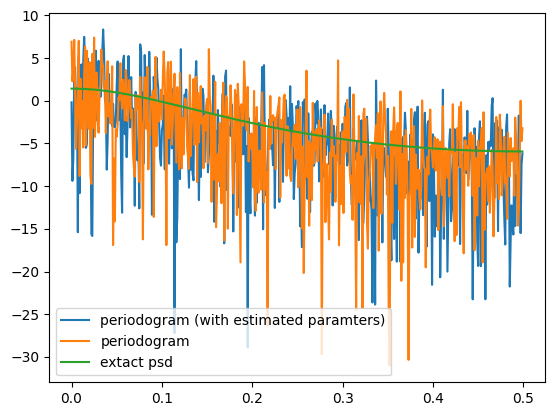

In [332]:
lpcoefs = lpc(X, order = 1)

X = AR(1000, [-1 * lpcoefs[1]], sigma2)

freqs, env = periodogram(X, plot=False)
env = 10 * np.log10(env)

plt.plot(freqs, env, label = "periodogram (with estimated paramters)")
plt.plot(freq1, per1, label = "periodogram")
plt.plot(freq1, theoritical_psd, label = "extact psd")
plt.legend()
plt.show()


#### 2. Sum of noisy sinusoids

##### 2.1 Synthesis

In [333]:
def sinusoids(N, K, freqs, ampls, originphi, sigma2):
    """
    function that synthesizes a signal of length N, consisting of the sum of K real sinusoids
    defined by their frequencies, amplitudes and origin phases, and a Gaussian white noise of variance σ2.         
    """
    wn = np.random.normal(0, np.sqrt(sigma2), N)
    sin = wn
    fs = 5000
    T = np.linspace(0, 1000, N)
    for i in range(K):
        sin += ampls[i] * np.sin(2*np.pi * freqs[i] * T + originphi[i])
    
    return sin

##### 2.2 Non parametric estimation : periodogram 

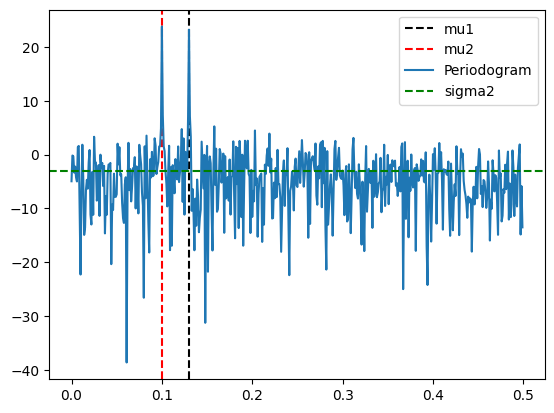

In [334]:
# signal synthesis
mu1, mu2 = 0.13, 0.1
sigma2 = 0.5
N = 1000
signal = sinusoids(N, K = 2, freqs=[mu1, mu2], originphi = [0, 0], sigma2 = sigma2, ampls = [1, 1])

freq_sinus, period_sinus = periodogram(signal, plot = False)

# to db
period_sinus = 10 * np.log10(period_sinus)

plt.axvline(mu1, color="black", linestyle="--", label = "mu1")
plt.axvline(mu2, color="red", linestyle="--", label = "mu2")
plt.plot(freq_sinus, period_sinus, label = "Periodogram")
plt.axhline(10*np.log10(sigma2), color="green", linestyle="--", label = "sigma2")
plt.legend()
plt.show()

SNR : 35.00885632516954


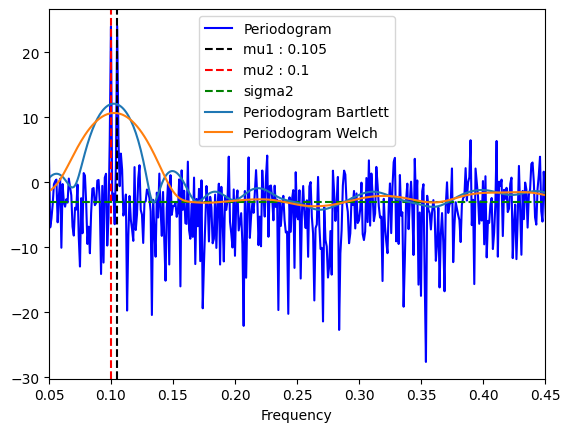

SNR : 34.74783379125795


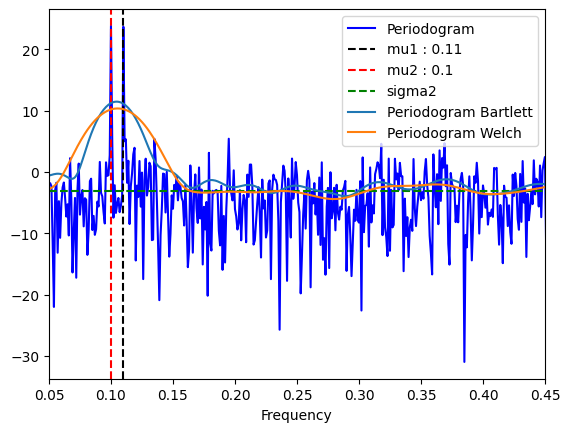

SNR : 34.50241597250454


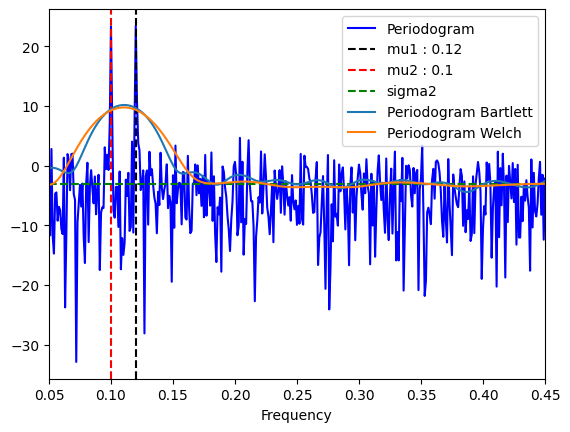

SNR : 35.00697254176137


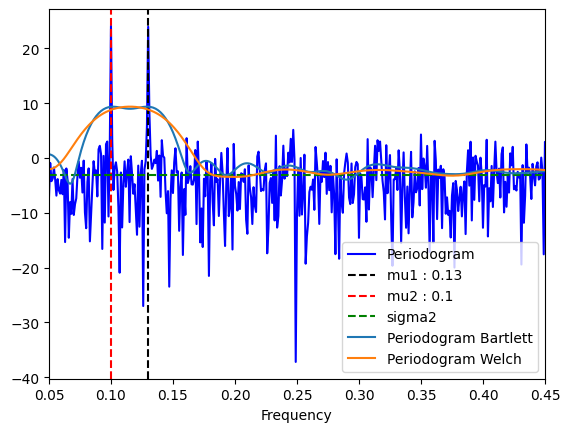

SNR : 34.62141772839122


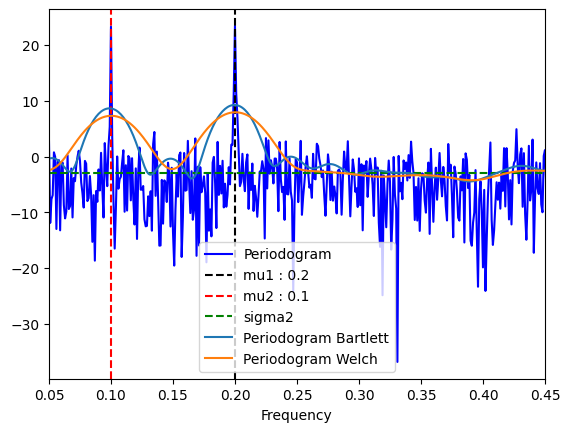

SNR : 32.81063159031055


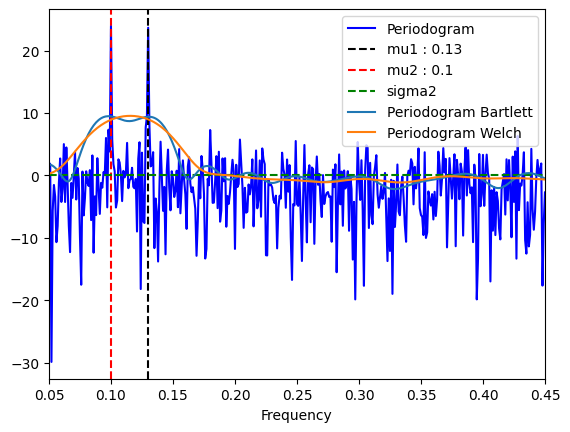

In [335]:
mu1 = [0.105, 0.11, 0.12, 0.13, 0.2, 0.3]
mu2 = 0.1
N = 1000
for i in range(6):
    if(i== 5):
        sigma2 = 1
        mu1[5] = 0.13
    signal = sinusoids(N, K = 2, freqs=[mu1[i], mu2], originphi = [0, 0], sigma2 = sigma2, ampls = [1, 1])

    freq_sinus, period_sinus = periodogram(signal, plot = False)
    
    # Periodogram with Bartlett method
    freq_sinus_b, period_sinus_b = periodogram(signal, Bartlett = True, plot = False)

    # Periodogram with Welch method
    freq_sinus_w, period_sinus_w = periodogram(signal, Welch = True, plot = False)

    # turn in to dB
    period_sinus = 10 * np.log10(period_sinus)
    period_sinus_b = 10 * np.log10(period_sinus_b)
    period_sinus_w = 10 * np.log10(period_sinus_w)

    # SNR
    SNR = 10 * np.log10(np.sum(np.abs(np.fft.fft(signal))**2) / (N * sigma2))
    print(f"SNR : {SNR}")

    plt.plot(freq_sinus, period_sinus, label = "Periodogram", color = "blue")
    plt.axvline(mu1[i], color="black", linestyle="--", label = f"mu1 : { mu1[i]}")
    plt.axvline(mu2, color="red", linestyle="--", label = "mu2 : 0.1")
    plt.axhline(10*np.log10(sigma2), color="green", linestyle="--", label = "sigma2")
    plt.plot(freq_sinus_b, period_sinus_b, label = "Periodogram Bartlett")
    plt.plot(freq_sinus_w, period_sinus_w, label = "Periodogram Welch")
    plt.xlabel("Frequency")
    plt.xlim(0.05, 0.45)
    plt.legend()
    plt.show()

Display the periodograms obtained with the standard method and the Bartlett and Welsh methods,
in the case of K = 2 sinusoidal frequencies ν1 and ν2, zero origin phase and same amplitude
equal to 1. We will superimpose in each case the periodogram with two vertical lines centered at
frequencies ν1 and ν2, and a horizontal line centered at the variance σ2.
3. Compare the resolution of the various periodograms, by varying the difference ∆ν = |ν1 − ν2|
between both frequencies, as well as the signal-to-noise ratio (SNR) in dB.

    we can see that the resolution of the periodogram is better when the difference between the two frequencies is large, and when the SNR is high. We can remark that the standard periodogram has a better resolution than the Bartlett and Welsh periodograms, but it is more sensitive to noise, as if the SNR is low, the noise risks to be interpreted as a frequency component of the signal.

##### 2.3 Parametric estimation : linear prediction

4. Estimate a fourth order AR model using the linear prediction method.

In [336]:
lpcoefs = lpc(signal, order = 4)

signal_estimated = AR(N, -1 * lpcoefs[1:], sigma2)

print(f"Estimated AR coefs : {-1*lpcoefs[1:]}")

Estimated AR coefs : [ 0.3237403   0.052977   -0.20655422 -0.31072493]


5.

SNR : 34.68005883635534


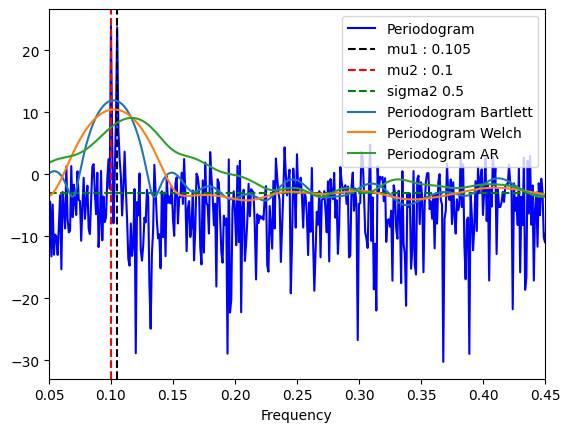

SNR : 35.02071914634013


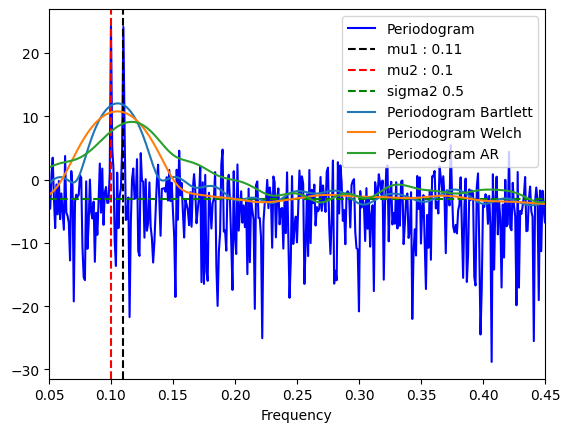

SNR : 34.90580602827142


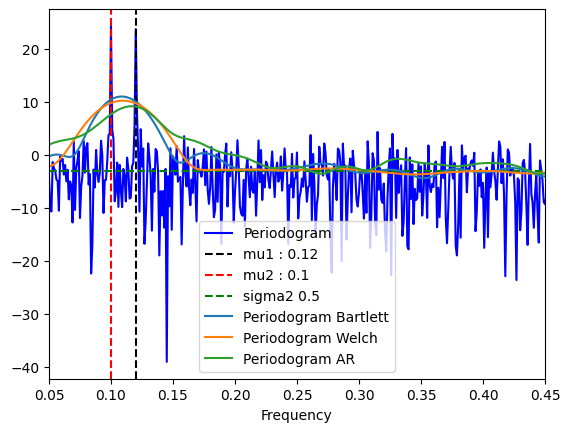

SNR : 34.51779059386931


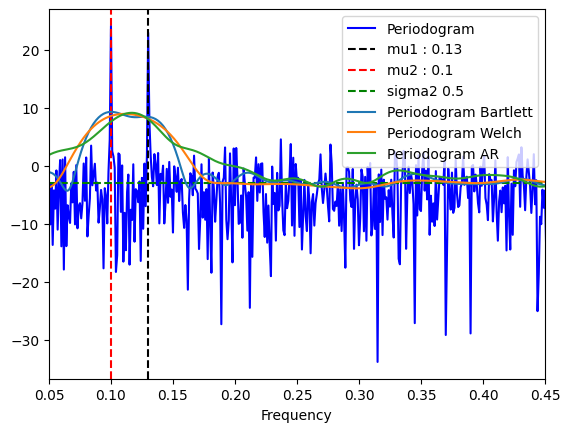

SNR : 34.864047749188146


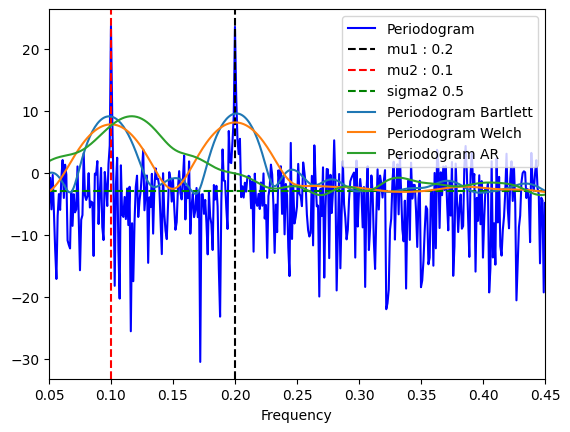

SNR : 32.99721218371835


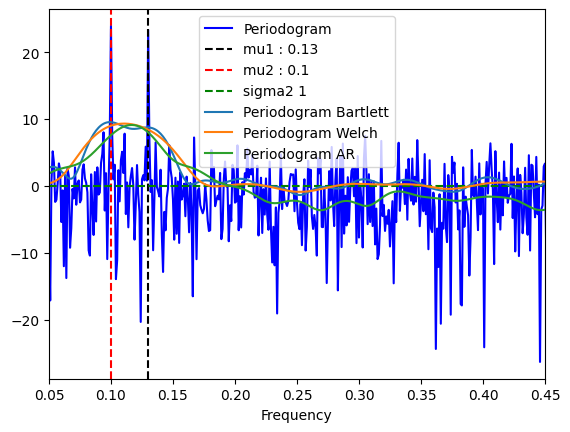

SNR : 31.443393729524768


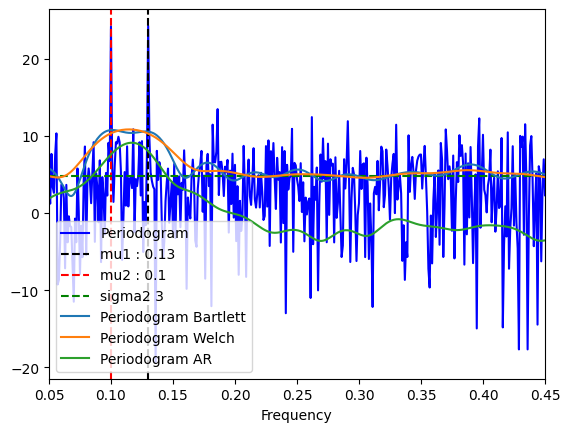

In [337]:
# Periodogram of the estimated signal
freq_sinus_AR, period_sinus_AR = periodogram(signal_estimated, Bartlett=True, plot = False)

# turn in to dB
period_sinus_AR = 10 * np.log10(period_sinus_AR)
mu1 = [0.105, 0.11, 0.12, 0.13, 0.2, 0.13, 0.13]
mu2 = 0.1
N = 1000
sigma2 = 0.5
for i in range(7):
    if(i== 5):
        sigma2 = 1
    if(i==6):
        sigma2 = 3
    signal = sinusoids(N, K = 2, freqs=[mu1[i], mu2], originphi = [0, 0], sigma2 = sigma2, ampls = [1, 1])

    freq_sinus, period_sinus = periodogram(signal, plot = False)
    
    # Periodogram with Bartlett method
    freq_sinus_b, period_sinus_b = periodogram(signal, Bartlett = True, plot = False)

    # Periodogram with Welch method
    freq_sinus_w, period_sinus_w = periodogram(signal, Welch = True, plot = False)

    # turn in to dB
    period_sinus = 10 * np.log10(period_sinus)
    period_sinus_b = 10 * np.log10(period_sinus_b)
    period_sinus_w = 10 * np.log10(period_sinus_w)

    # SNR
    SNR = 10 * np.log10(np.sum(np.abs(np.fft.fft(signal))**2) / (N * sigma2))
    print(f"SNR : {SNR}")

    plt.plot(freq_sinus, period_sinus, label = "Periodogram", color = "blue")
    plt.axvline(mu1[i], color="black", linestyle="--", label = f"mu1 : { mu1[i]}")
    plt.axvline(mu2, color="red", linestyle="--", label = "mu2 : 0.1")
    plt.axhline(10*np.log10(sigma2), color="green", linestyle="--", label = f"sigma2 {sigma2}")
    plt.plot(freq_sinus_b, period_sinus_b, label = "Periodogram Bartlett")
    plt.plot(freq_sinus_w, period_sinus_w, label = "Periodogram Welch")
    plt.plot(freq_sinus_AR, period_sinus_AR, label = "Periodogram AR")
    plt.xlabel("Frequency")
    plt.xlim(0.05, 0.45)
    plt.legend()
    plt.show()

Comment on the results in terms of resolution.

    We can see that the resolution periodogram of the estimated AR model is the worst, and that the estimated frequencies are not exactly the same as the true frequencies. This is due to the fact that the AR model is of order 4, and that the signal is composed of two sinusoids. The AR model is not able to represent the signal exactly, and the periodogram of the estimated AR model has a higher variance than the periodograms of the standard, Bartlett and Welsh methods, and this periodogram is too sensitive to noise, as we can see in the last figure.

#### 2.4 Parametric estimation : Capon method

6. Code a function that implements the Capon estimator.

In [338]:
def capon_estimator(signal, N=500):
    """
    Capon method
    """
    # estimation of the autocorrelation matrix
    R = np.zeros((len(signal), len(signal)), dtype = complex)
    for i in range(len(signal)):
        R[0, i] = sum([signal[k+i] * signal[k] for k in range(len(signal) - i)])
    
    for i in range(1, len(signal)):
        R[i,:] = np.roll(R[i-1,:], 1)
    R = R / len(signal)

    R_inv = np.linalg.inv(R)
    
    freq = np.fft.fftfreq(len(signal))
    Scap = []
    for f in freq:
        emu = []
        for i in range(len(signal)):
            emu.append(np.exp(2j * np.pi * f * i))

        emu = np.array(emu)

        Scap_mu = np.dot(np.conj(emu), np.dot(R_inv, emu))
        Scap_mu = N / Scap_mu
        Scap.append(Scap_mu)
    
    Scap = np.array(Scap)
    return Scap[freq>= 0], freq[freq>=0]

7. Compare the resolution of this method with the two previous methods, always by varying ∆ν, as well as the SNR in dB.

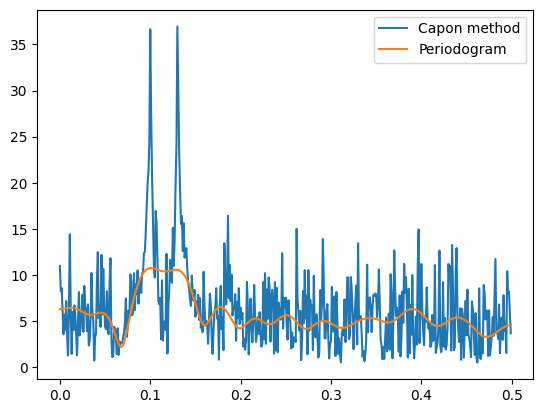

In [339]:
# Capon method
Scap, freqs = capon_estimator(signal)
Scap = np.abs(Scap)**2
Scap = 10 * np.log10(Scap)

# Standard periodogram
freq_sinus, period_sinus = periodogram(signal, Bartlett=True, plot = False)
period_sinus = 10 * np.log10(period_sinus)

plt.plot(freqs, Scap, label = "Capon method")
plt.plot(freq_sinus, period_sinus, label = "Periodogram")
plt.legend()
plt.show()

    First, comparing the resolution of the Capon method with the resolution of the standard periodogram, we can see that the Capon method emphasizes the frequencies of the signal, and that the resolution of the Capon method is way better than the resolution of the standard periodogram. The Capon method is also less sensitive to noise than the standard periodogram, as we can see in the figure.

SNR : 34.59449048896364


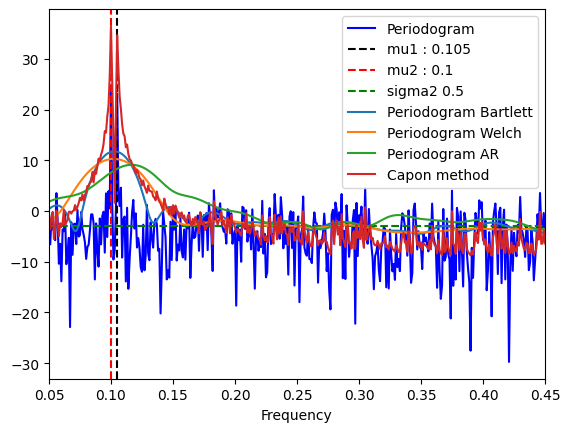

SNR : 34.62105752747731


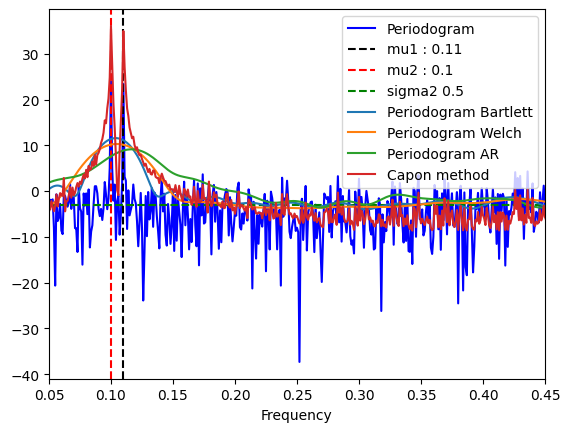

SNR : 34.824199028560756


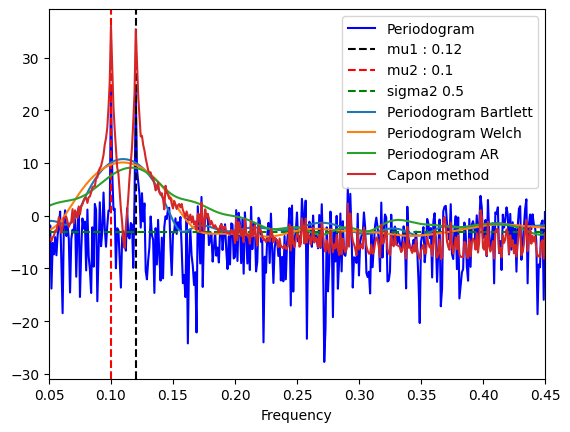

SNR : 34.62331930040257


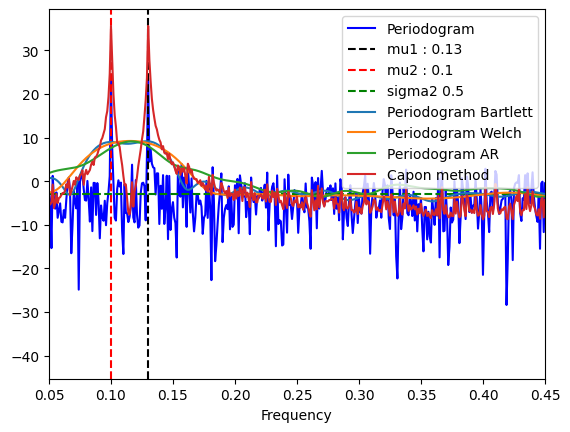

SNR : 34.82340476039389


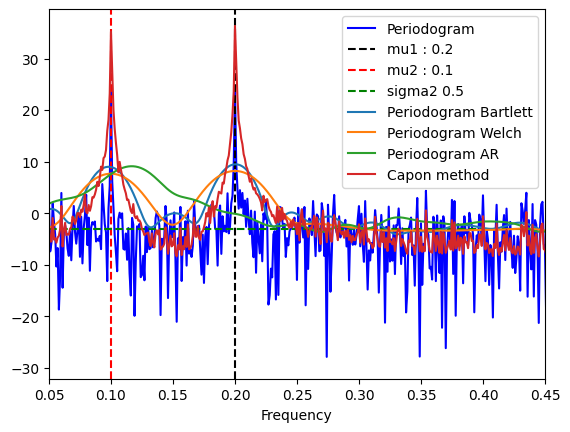

SNR : 33.181624237646986


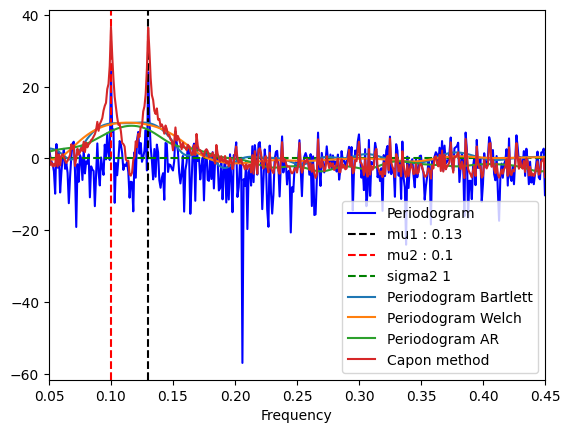

SNR : 31.304006079091845


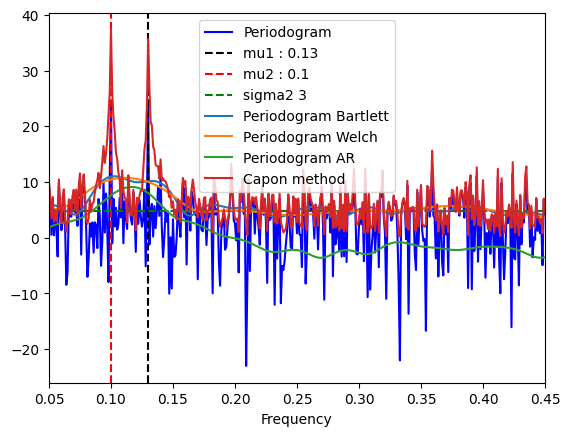

In [340]:
# Periodogram of the estimated signal
freq_sinus_AR, period_sinus_AR = periodogram(signal_estimated, Bartlett=True, plot = False)

# turn in to dB
period_sinus_AR = 10 * np.log10(period_sinus_AR)
mu1 = [0.105, 0.11, 0.12, 0.13, 0.2, 0.13, 0.13]
mu2 = 0.1
N = 1000
sigma2 = 0.5
for i in range(7):
    if(i== 5):
        sigma2 = 1
    if(i==6):
        sigma2 = 3
    signal = sinusoids(N, K = 2, freqs=[mu1[i], mu2], originphi = [0, 0], sigma2 = sigma2, ampls = [1, 1])

    freq_sinus, period_sinus = periodogram(signal, plot = False)
    
    # Periodogram with Bartlett method
    freq_sinus_b, period_sinus_b = periodogram(signal, Bartlett = True, plot = False)

    # Periodogram with Welch method
    freq_sinus_w, period_sinus_w = periodogram(signal, Welch = True, plot = False)
    # capon method
    Scap, freqs = capon_estimator(signal)
    Scap = np.abs(Scap)**2
    Scap = 10 * np.log10(Scap)
    
    # turn in to dB
    period_sinus = 10 * np.log10(period_sinus)
    period_sinus_b = 10 * np.log10(period_sinus_b)
    period_sinus_w = 10 * np.log10(period_sinus_w)

    # SNR
    SNR = 10 * np.log10(np.sum(np.abs(np.fft.fft(signal))**2) / (N * sigma2))
    print(f"SNR : {SNR}")

    plt.plot(freq_sinus, period_sinus, label = "Periodogram", color = "blue")
    plt.axvline(mu1[i], color="black", linestyle="--", label = f"mu1 : { mu1[i]}")
    plt.axvline(mu2, color="red", linestyle="--", label = "mu2 : 0.1")
    plt.axhline(10*np.log10(sigma2), color="green", linestyle="--", label = f"sigma2 {sigma2}")
    plt.plot(freq_sinus_b, period_sinus_b, label = "Periodogram Bartlett")
    plt.plot(freq_sinus_w, period_sinus_w, label = "Periodogram Welch")
    plt.plot(freq_sinus_AR, period_sinus_AR, label = "Periodogram AR")
    plt.plot(freqs, Scap, label = "Capon method")
    plt.xlabel("Frequency")
    plt.xlim(0.05, 0.45)
    plt.legend()
    plt.show()

    We can clearly see that the Capon method has a better resolution than the Bartlett and Welsh methods, and that the Capon method is less sensitive to noise than the Bartlett and Welsh methods. And as expected the Capon method has a lower variance then the standard periodogram. And that's the compromise that the Capon method offers, a better resolution but a higher variance than the Bartlett and Welsh methods, and lower than the standard periodogram.

#### 3. Autoregressive-moving-average process

##### 3.1 Synthesis

1. Code a function that synthesizes an autoregressive-moving-average (ARMA) process of length N, defined by its AR and MA coefficients and by the innovation variance σ2.

In [18]:
def arma(a, b, sigma2, N = 10000):
    """
    Synthesis of an ARMA process
    """
    Z = np.random.normal(0, np.sqrt(sigma2), N)
    X = Z
    a = [1] + a
    b = [1] + b
    for i in range(N):   
        # AR part
        for j in range(1, len(a)):
            if(i-j >= 0):
                X[i] += a[j] * X[i-j]
        # MA part
        for j in range(1, len(b)):
            if (i-j >=0):
                X[i] += b[j] * Z[i-j] 
    
    return X

#### 3.2 Non-parametric estimation : periodogram

2.

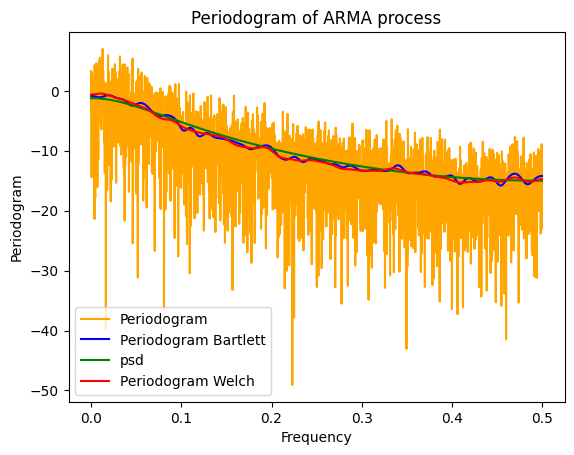

In [19]:
# Synthesis
a = [0.6]
b = [0.1]
sigma2_arma = 0.1
ARMA = arma(a, b, sigma2_arma, N = 5000)

# periodogram of the ARMA process
freq_arma, period_arma = periodogram(ARMA, plot=False)
period_arma = 10 * np.log10(period_arma)

# PSD
psd_arma = [(sigma2_arma * (np.abs(1 + b[0] * np.exp(-2j*np.pi*f))**2) / (np.abs(1 - a[0]*np.exp(-2j*np.pi*f))**2)) for f in freq_arma]
psd_arma = 10 * np.log10(psd_arma)

# periodogram with Bartlett method
freq_arma_b, period_arma_b = periodogram(ARMA, Bartlett=True, plot=False)
period_arma_b = 10 * np.log10(period_arma_b)

# periodogram with Welch method
freq_arma_w, period_arma_w = periodogram(ARMA, Welch=True, plot=False)
period_arma_w = 10 * np.log10(period_arma_w)

# -----------------------------------
plt.plot(freq_arma, period_arma, label = "Periodogram", color = "orange")
plt.plot(freq_arma_b, period_arma_b, label = "Periodogram Bartlett", color="blue")
plt.plot(freq_arma, psd_arma, label = "psd", color = "green")
plt.plot(freq_arma_w, period_arma_w, label = "Periodogram Welch", color = "red")

plt.xlabel("Frequency")
plt.ylabel("Periodogram")
plt.title("Periodogram of ARMA process")
plt.legend()
plt.show()

    As expected, we can see that the methods give an estimation with low varaince of the PSD of the ARMA process, except the standard periodogram, which has a high varaince.

In [22]:
bias1_arma = np.mean(psd_arma - period_arma)
var1_arma = np.var(psd_arma - period_arma)

bias2_arma = np.mean(psd_arma - period_arma_b)
var2_arma = np.var(psd_arma - period_arma_b)

bias3_arma = np.mean(psd_arma - period_arma_w)
var3_arma = np.var(psd_arma - period_arma_w)

print('Bias and variance of the periodogram estimates')
print('---------------------------------------------')
print('Periodogram :')
print('Bias : ', bias1_arma)
print('Variance : ', var1_arma)
print('---------------------------------------------')
print('Periodogram Bartlett :')
print('Bias : ', bias2_arma)
print('Variance : ', var2_arma)
print('---------------------------------------------')
print('Periodogram Welch :')
print('Bias : ', bias3_arma)
print('Variance : ', var3_arma)

Bias and variance of the periodogram estimates
---------------------------------------------
Periodogram :
Bias :  2.7397419965864493
Variance :  31.671376734826925
---------------------------------------------
Periodogram Bartlett :
Bias :  0.16540761371583831
Variance :  0.29596789814485946
---------------------------------------------
Periodogram Welch :
Bias :  0.28985004886332144
Variance :  0.2283580071944216


    We can say the same thing as in the previous section, the Bartlett and Welsh methods have a lower variance than the standard method, and the bias is reduced by this methods as well.

##### 3.3 Parametric estimation : Durbin method

In [ ]:
def durbin(autocorr, p , q, freqs):
    """
    Durbin algorithm
    """
    
    ## --- estimating the AR part --- ##
    # ------- Initialization
    a = np.zeros(p+1)
    a[0] = 1
    rho = autocorr[1:]
    sigma2 = np.zeros(p+1)

    a[1] = rho[1] / rho[0]
    sigma2[1] = rho[0] - (np.abs(rho[1])**2 / rho[0])

    k = np.zeros(p+1)
    k[0] = 1
    k[1] = -a[1]
    for n in range(1, p):
        # a_n+1
        k[n+1] = - (rho[n+1] - np.sum([a[j] * rho[j] for j in range(1, n+1)])) / sigma2[n]
        # sigma2_n+1
        sigma2[n+1] = sigma2[n] * (1 - np.abs(k[n+1])**2)
        # a0 to a_n
        a[:n+1] = np.concatenate((a[:n], [0])) - k[n+1] * np.concatenate((np.conj(a[:n]), [-1]))

    print(f"Estimated AR coefs : {a}")
    ## we now have the AR part 
    
    # |A(z)|^2
    A = []
    for i in range(len(freqs)):
        A.append(np.abs(1 - np.sum([a[j] * np.exp(-2j*np.pi*freqs[i]*j) for j in range(1, p+1)]))**2)    
    
    
    ## --- estimating the MA part --- ##
    L = 1000*q
    # ------- We first estimate the autocorrelation of the AR part
    rho = np.zeros(L+1)
    for i in range(L+1):
        rho[i] = np.sum([a[j] * autocorr[i-j] for j in range(1, p+1)])
        
    # ------- We solve the Yule-Walker equations ( same as for the AR part )
    rho = rho[1:]
    aL = np.zeros(L+1)
    aL[0] = 1
    rho = autocorr
    sigma2_ = np.zeros(L+1)

    aL[1] = rho[1] / rho[0]
    sigma2_[1] = rho[0] - (np.abs(rho[1])**2 / rho[0])

    k = np.zeros(L+1)
    k[0] = 1
    k[1] = -aL[1]
    for n in range(1, L):
        k[n+1] = - (rho[n+1] - np.sum([aL[j] * rho[j] for j in range(1, n+1)])) / sigma2_[n]
        sigma2_[n+1] = sigma2_[n] * (1 - np.abs(k[n+1])**2)
        aL[:n+1] = np.concatenate((aL[:n], [0])) - k[n+1] * np.concatenate((np.conj(aL[:n]), [-1]))

    # |AL(z)|^2
    AL = []
    for i in range(len(freqs)):
        AL.append(np.abs(1 - np.sum([aL[j] * np.exp(-2j*np.pi*freqs[i]*j) for j in range(1, q+1)]))**2)
    
    # S estimated
    S = []
    for i in range(len(freqs)):
        S.append(1 / (A[i] * AL[i]))
    print(f"sigma2: {(sigma2[-1] / sigma2_[-1])}")

    S = np.array(S)* (sigma2[-1] / sigma2_[-1])

    return S, sigma2[-1] / sigma2_[-1]

In [ ]:
a = [0.6]
b = [0.1]
sigma2_arma = 0.1
ARMA = arma(a, b, sigma2_arma, N = 5000)

Estimated AR coefs : [1.         0.69235119]
sigma2: 0.26380654343559373


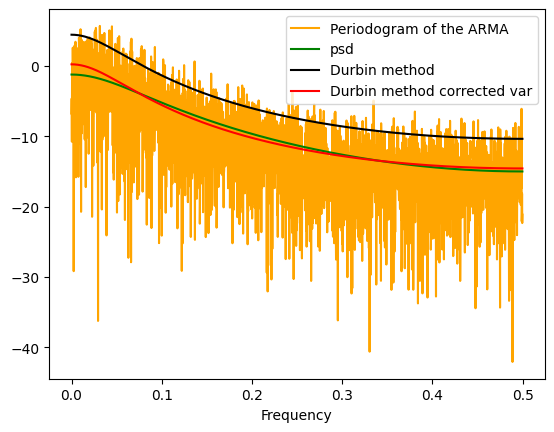

In [ ]:
arma_autocorr = np.zeros(len(ARMA))
for i in range(len(ARMA)):
    arma_autocorr[i] = sum([ARMA[k+i] * ARMA[k] for k in range(len(ARMA) - i)]) 
arma_autocorr = arma_autocorr / len(ARMA)

freq_arma = np.fft.fftfreq(len(ARMA))
psd_est_durbin, estimated_var = durbin(arma_autocorr, 1, 1, freq_arma[freq_arma >= 0])

psd_est_durbin_dB = 10 * np.log10( psd_est_durbin)

# correcting the variance
psd_est_durbin_corrected_var = 10 * np.log10( (sigma2_arma/ estimated_var) * psd_est_durbin)

# periodogram of the ARMA process
freq_arma, period_arma = periodogram(ARMA, plot=False)
period_arma = 10 * np.log10(period_arma)

# Theoretical PSD
psd_arma = [(sigma2_arma * (np.abs(1 + b[0] * np.exp(-2j*np.pi*f))**2) / (np.abs(1 - a[0]*np.exp(-2j*np.pi*f))**2)) for f in freq_arma]
psd_arma = 10 * np.log10(psd_arma)


# plot
plt.plot(freq_arma, period_arma, label = "Periodogram of the ARMA", color = "orange")
plt.plot(freq_arma, psd_arma, label = "psd", color = "green")
plt.plot(freq_arma, psd_est_durbin_dB, label = "Durbin method", color = "black")
plt.plot(freq_arma, psd_est_durbin_corrected_var, label = "Durbin method corrected var", color = "red")
plt.xlabel("Frequency")
plt.legend()
plt.show()

    The algorithm fails for some reason to estimate the variance. That's why the estimated PSD via the Durbin method is a translated from the true PSD. When the variance is estimated correctly ( I corrected the varaiance, the red plot), the estimated PSD via the Durbin method is the same as the true PSD modulo some minuscule differences.

##### 3.4 Application to speech signals

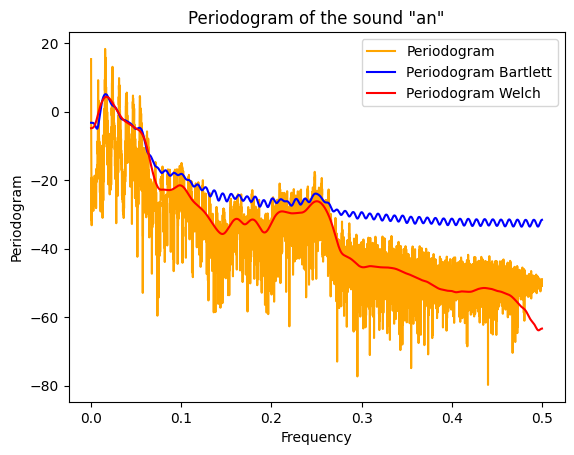

In [ ]:
# import the sound
fs, signal = wavfile.read('sounds/an_in_on.wav')
signal = signal / max(signal)

# extract "an" from the signal
an = signal[0:int(fs / 2) + 4250]

# play the sound
Audio(data=an, rate=fs)

# periodogram of the signal
freq_an, period_an = periodogram(an, plot=False)
period_an = 10 * np.log10(period_an)

# periodogram with Bartlett method
freq_an_b, period_an_b = periodogram(an, Bartlett=True, plot=False)
period_an_b = 10 * np.log10(period_an_b)

# periodogram with Welch method
freq_an_w, period_an_w = periodogram(an, Welch=True, plot=False)
period_an_w = 10 * np.log10(period_an_w)


# plot
plt.plot(freq_an, period_an, label = "Periodogram", color = "orange")
plt.plot(freq_an_b, period_an_b, label = "Periodogram Bartlett", color="blue")
plt.plot(freq_an_w, period_an_w, label = "Periodogram Welch", color = "red")

plt.xlabel("Frequency")
plt.ylabel("Periodogram")
plt.title("Periodogram of the sound \"an\"")
plt.legend()
plt.show()

In [ ]:
in_ = signal[int(fs / 2) + 4250:int(fs)+4000]

Audio(data=in_, rate=fs)

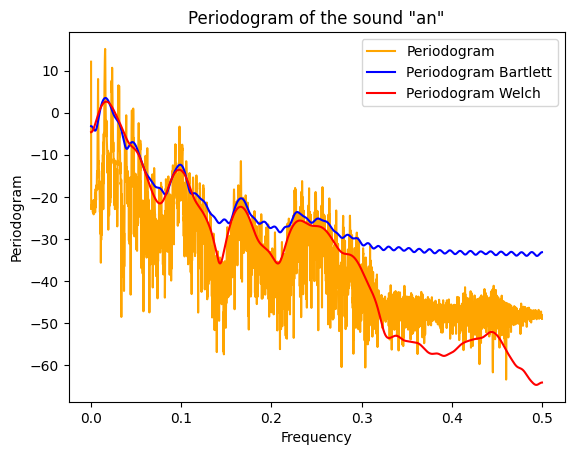

In [ ]:
# periodogram of the signal
freq_an, period_an = periodogram(in_, plot=False)
period_an = 10 * np.log10(period_an)

# periodogram with Bartlett method
freq_an_b, period_an_b = periodogram(in_, Bartlett=True, plot=False)
period_an_b = 10 * np.log10(period_an_b)

# periodogram with Welch method
freq_an_w, period_an_w = periodogram(in_, Welch=True, plot=False)
period_an_w = 10 * np.log10(period_an_w)


# plot
plt.plot(freq_an, period_an, label = "Periodogram", color = "orange")
plt.plot(freq_an_b, period_an_b, label = "Periodogram Bartlett", color="blue")
plt.plot(freq_an_w, period_an_w, label = "Periodogram Welch", color = "red")

plt.xlabel("Frequency")
plt.ylabel("Periodogram")
plt.title("Periodogram of the sound \"an\"")
plt.legend()
plt.show()

    We can remark that the Bartlett method struglles to estimate the PSD, especially with high frequencies, this can be due spectral leakage caused by segmenting the data. And we can see that the Welch method improves the estimation, mitigating the issue by overlapping segments and applying a window. We can thus imporve the estimation by increasing the number of segments, and the length of the segments, and by using a different window.

    Let's try with "a".

In [5]:
fs, signal = wavfile.read('sounds/aeiou.wav')

signal = signal / max(signal)

a = signal[:int(fs/2)+4500]

Audio(data=a, rate=fs)

In [6]:
# periodogram of the signal
freq_a, period_a = periodogram(a, plot=False)
period_a = 10 * np.log10(period_a)

# periodogram with Bartlett method
freq_a_b, period_a_b = periodogram(a, Bartlett=True, plot=False)
period_a_b = 10 * np.log10(period_a_b)

# periodogram with Welch method
freq_a_w, period_a_w = periodogram(a, Welch=True, plot=False)
period_a_w = 10 * np.log10(period_a_w)

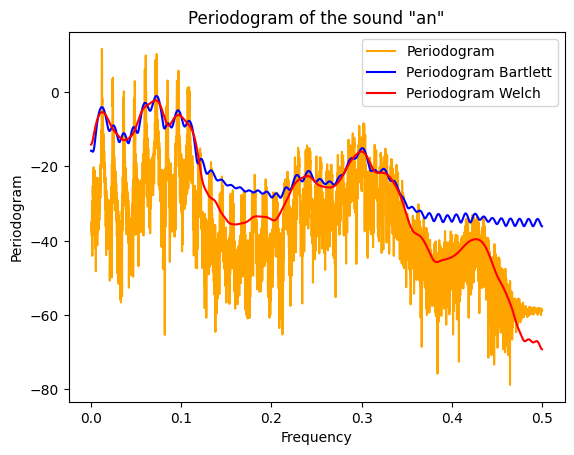

In [7]:
# plot
plt.plot(freq_a, period_a, label = "Periodogram", color = "orange")
plt.plot(freq_a_b, period_a_b, label = "Periodogram Bartlett", color="blue")
plt.plot(freq_a_w, period_a_w, label = "Periodogram Welch", color = "red")

plt.xlabel("Frequency")
plt.ylabel("Periodogram")
plt.title("Periodogram of the sound \"a\"")
plt.legend()
plt.show()

    If we take half the "a". We observe the same phenomenon as before.

In [12]:
a = a[len(a)//2:]
Audio(data=a, rate=fs)

In [14]:
# periodogram of the signal
freq_a, period_a = periodogram(a, plot=False)
period_a = 10 * np.log10(period_a)

# periodogram with Bartlett method
freq_a_b, period_a_b = periodogram(a, Bartlett=True, plot=False)
period_a_b = 10 * np.log10(period_a_b)

# periodogram with Welch method
freq_a_w, period_a_w = periodogram(a, Welch=True, plot=False)
period_a_w = 10 * np.log10(period_a_w)

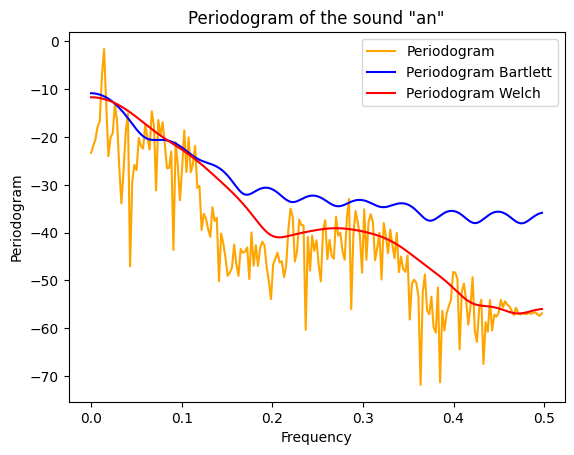

In [15]:
# plot
plt.plot(freq_a, period_a, label = "Periodogram", color = "orange")
plt.plot(freq_a_b, period_a_b, label = "Periodogram Bartlett", color="blue")
plt.plot(freq_a_w, period_a_w, label = "Periodogram Welch", color = "red")

plt.xlabel("Frequency")
plt.ylabel("Periodogram")
plt.title("Periodogram of the sound \"a\"")
plt.legend()
plt.show()